# Community detection on the Wikipedia hyperlink graph

Team members: 
* Armand Boschin
* Bojana Ranković
* Quentin Rebjock

Please go through the README.md [file](https://github.com/armand33/wikipedia_graph/blob/master/README.md) beforehand.

**NB**:
* Please take the time to download the pickle file `shortest_paths.pkl` from this [link](https://drive.google.com/file/d/17bXr-OKY8xrUhCDfwR0WwP9uTOXeKG9d/view?usp=sharing). It should be put in the directory `data/`.
* Some cells are not executed and are in comments because they are really long. All the output files are directly dumped into pickle files. Those should be present in the directory `data/`.
    - scraping step ($\sim 3$ hours) : `network.pkl`
    - shortest-paths step ($\sim 5$ hours) : `shortest_paths.pkl`
    - cross-validation step ($\sim 1$ hour) : `cross_val.pkl`

This is a reminder of the project proposal adapted to the reality of the project:

***Graph:*** Wikipedia hyperlink network

***Problem:*** Does the structure of the graph bears info on the content of the nodes ? We would like to find out if it is possible to detect communities of pages just by looking at the hyperlink connections and match these communities with real-world data such as categories of the pages. Is spectral clustering a viable possibility compared to proven method of community detection.

***Steps of the project:***
* Scraping the Wikipedia hyperlink network. Start from one node and get the pages as far as 2 or 3 hops depending on the number of nodes we get.
* Model the network by a random graph/scale-free network/something else in order to try to retrieve some of its characteristics.
* Apply Louvain algorithm for community detection to get a baseline to compare spectral clustering to. Indeed in term of community detection, Louvain is quite usual and our approach is to test the performance of spectral clustering.
* Try to apply spectral clustering in order to detect communities of pages.
* Visualize the clusters to match them with real-world categories (using some of the tools from the last guest lecture).

## Table of contents
* [**1) Data Acquisition**](#Data Acquisition)
<br><br>
* [**2) Data Exploration**](#Data Exploration)
<br><br>
* [**3) Data Exploitation**](#Data Exploitation)
    - [3.1) Modelisation of the network](#Modelisation of the network)
        - [*3.1.1) Exploration of the degree distribution*](#Exploration of the degree distribution)
        - [*3.1.2) Modelisation with usual graphs models*](#Modelisation with usual graphs models)
        - [*3.1.3) A power law network with the right exponent*](#A power law network with the right exponent)
        - [*3.1.4 Comparison of the models*](#Comparison of the models)
        - [*3.1.5) Comparison with common networks from the web*](#Comparison with common networks from the web) <br><br>
    - [3.2) Community detection using Spectral clustering](#Community detection using Spectral clustering)
        - [*3.2.1) Louvain community detection*](#Louvain community detection)
        - [*3.2.2) Spectral Clustering*](#Spectral Clustering)
        - [*3.2.3 Comparison of the two methods*](#Comparison of the two methods)
        - [*3.2.4 Visualization*](#3.2.4Visualization)
<br><br>
* [**4) Conclusion**](#Conclusion)

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import operator
import community

from scipy import linalg, cluster, sparse
from tqdm import tqdm_notebook

from utils import load_obj, save_obj

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1) Data Acquisition <a class="anchor" id="Data Acquisition"></a>

We want to acquire a sub-network of the Wikipedia hyperlink network. In such a graph, each node is a Wikipedia page and there is a link between node $a$ and node $b$ if there is a link to page $b$ on page $a$. This is a directed network but we will make it undirected later on.

The process of the acquisition is the following : 
* Start from an arbitrary root page (prefer an ambiguous page in order to get as many different communities as possible).
* Explore this page to get the intra-wiki links : the first nodes.
* For each first node, explore the intra-wiki links to get the second nodes.
* Look for inner connections (links from second nodes to first nodes tipically).
* Eventually, for each node, take the intersection of its neighbor with the collected nodes (it can be that some nodes have neighbors that have not been collected, for example a second node that has been collected from a disambiguation page).


We use the `Wikipedia` API that allows us to scrap pages and get links and categories for each one. We chose to include in our network only real pages (not the disambiguation ones). Those pages are indeed useful during the scraping because they allow us to get a larger sample of the real graph. Disambiguation pages act like bridges between pages that have nothing to do together.

For each node we need to get URL, title, categories and links to other pages.

We use as `root_node` the disambiguation page Jaguar (disambiguation) as it lists a really wide variety of themes (animals, cars, music, films, weapons...). It can lead us to a large selection of categories.


The function `explore_page` is implemented in the file `utils.py`. All implementation details are provided there.

In [ ]:
from utils import explore_page

In [ ]:
root_node = 'Jaguar (disambiguation)'

network = {}  # This dict stores for each page a dictionnary containing the keys [url, links, categories]
first_nodes = []

explore_page(root_node, network, first_nodes)

second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

Look for connections between second nodes and the rest of the nodes.

In [ ]:
all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

The above cell took 2 hours and 47 minutes to run (duration of scraping).

Now we need to go through all the nodes in order to remove from their neighbors any page that has not been scraped.

In [ ]:
all_nodes = list(network.keys())
for title in tqdm_notebook(network.keys()):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))

The previous step can lead to pages with no neighbor (if a second node comes from a disambiguation page and all its neigbors are not in first or second nodes).

In [ ]:
l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]

#### Cleaning the categories

There are some categories for each page that are irrelevant in our work (e.g. "All articles with unsourced statements"). We need to get rid of those.

In [ ]:
for i, title in enumerate(network.keys()):
    cats = network[title]['categories']
    new_cats = []
    for c in cats:
        if not c.startswith('Redundant') and not c.startswith('Pages') and not c.startswith('Webarchive') and not c.startswith('Wikipedia') and not c.startswith('Articles') and not c.startswith('Coordinates on Wikidata') and not 'Wikidata' in c and not c.startswith('CS1') and not c.startswith('EngvarB') and not c.startswith('All') and not c.startswith('Good articles') and not c.startswith('Use dmy'):
            new_cats.append(c)
    network[title]['categories'] = new_cats

#### Creating pickle files

As the scraping of the network takes quite some time ($\sim$ 3 hours) (especially getting the inner connections), we store the results in pickle files.

In [3]:
# save_obj(network, 'network')
network = load_obj('network')

### Network creation

Let's convert the collected network into a NetworkX instance which is quite handy to manipulate.

Let's make it undirected as well.

In [4]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [5]:
g = nx.Graph(neighbors)  # undirected graph

# 2) Data Exploration  <a class="anchor" id="Data Exploration"></a>

In this part of the notebook, we provide some indicators of the data in order to understand what we'll be working on.

* Adjacency matrix
* Degrees distribution
* Average degree
* Diameter of the collected network
* Visualization of the network

In [6]:
print('Total number of nodes : {}'.format(len(g.nodes)))
print('Total number of edges : {}'.format(len(g.edges)))
if nx.is_connected(g):
    print('The graph is connected.')
else:
    print('The graph is not connected.')

Total number of nodes : 6830
Total number of edges : 367274
The graph is connected.


#### Adjacency Matrix

In [6]:
adj = nx.adjacency_matrix(g)

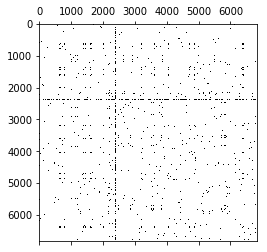

In [8]:
plt.spy(adj.todense())

Check if it's symmetric :

In [9]:
(adj != adj.T).count_nonzero() == 0

True

#### Degrees distribution

As there are some clear outliers making the visualization difficult, we can truncate the degrees or just use a box plot.

In [7]:
degrees = np.array(adj.sum(axis=1)).squeeze()
degrees_truncated = degrees[degrees < 700]

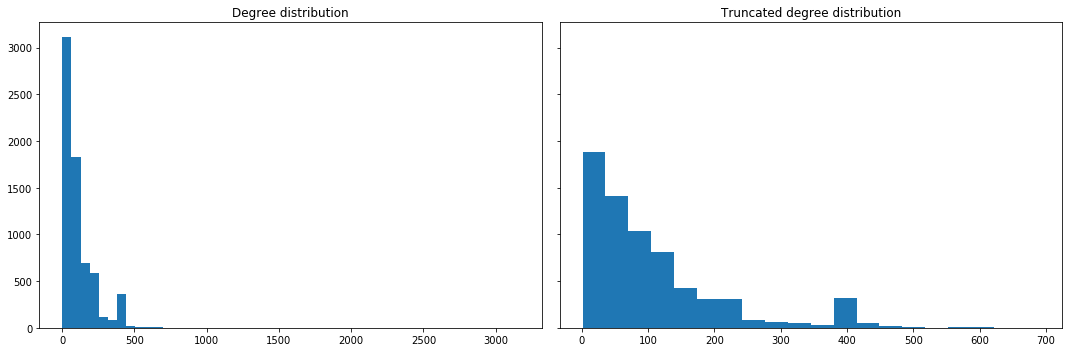

In [11]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree distribution')
ax[0].hist(degrees, bins=50)

ax[1].set_title('Truncated degree distribution')
ax[1].hist(degrees_truncated, bins=20)

plt.tight_layout()
plt.show()

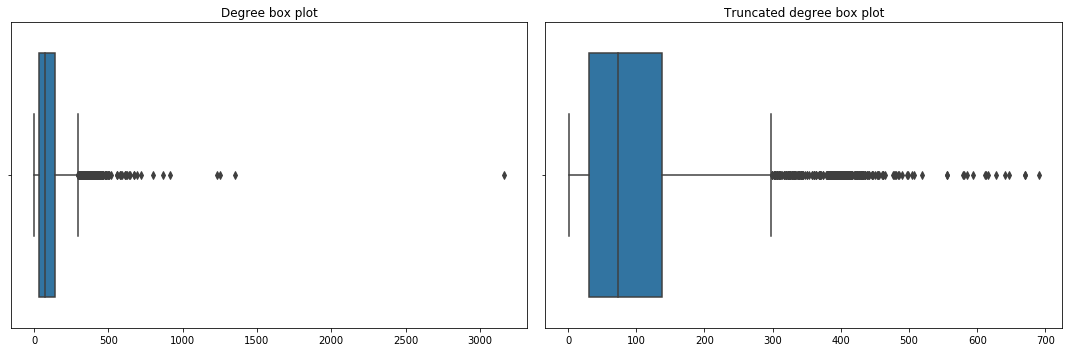

In [12]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree box plot')
sns.boxplot(degrees, ax=ax[0])

ax[1].set_title('Truncated degree box plot')
sns.boxplot(degrees_truncated, ax=ax[1])

plt.tight_layout()
plt.show()

#### Average degree

In [13]:
avg_degree = np.mean(degrees)
print('The average degree of the network is {}.'.format(np.round(avg_degree, 2)))

The average degree of the network is 107.55.


#### Diameter

First we compute the shortest paths lengths. NetworkX allows us to do the computation and returns a dictionnary. This will be useful later on.

In [14]:
# shortest_paths = dict(nx.shortest_path_length(g))
# save_obj(shortest_paths, 'shortest_paths')

As this computation is quite long ($\sim$ 5 hours), we dumped the resulting dictionnary in a pickle file.

In [16]:
shortest_paths = load_obj('shortest_paths')

Now the computing the diameter of the networks comes down to finding the largest distance. Let's turn the dictionnary into a numpy array that is faster to manipulate.

In [17]:
nodes = list(network.keys())

In [18]:
distances = np.zeros(shape=(len(nodes), len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        distances[i, j] = shortest_paths[nodes[i]][nodes[j]]

In [19]:
diameter = np.amax(distances)
print('The diameter of the network is {}.'.format(int(diameter)))

The diameter of the network is 5.


At first sight, if we had scraped first nodes and then second nodes, we should have had a diameter less than 4. Because a node should be at distance at most 2 from the root node.

Here, thanks to the use of disambiguation pages, we manage to get nodes that are further away from the root node but surprisingly our graph is connected anyway.

#### Visualization

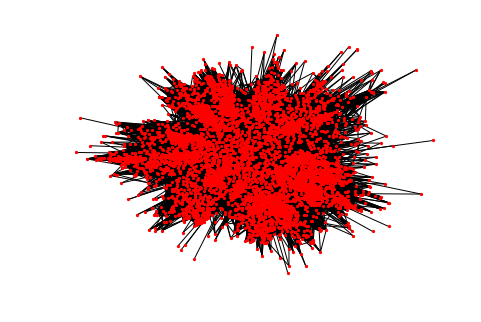

In [20]:
nx.draw(g, node_size=5, figsize=(15, 15))

# 3) Data Exploitation <a class="anchor" id="Data Exploitation"></a>

## 3.1) Modelisation of the network <a class="anchor" id="Modelisation of the network"></a>

In this section, we are trying to model the collected network with a simpler one, trying to get the same main features like the number of nodes, the number of edges, the degree distribution, the shape of the giant components, and so on. Such a model is particularly useful to understand the original structure and compare it to other famous and already known networks.

In this modelisation part, we are using functions implemented in the `utils.py` in order to plot degree distributions and to get the regression coefficient of a power law.

In [8]:
from utils import get_distribution, linear_regression_coefficient
from utils import plot_degree_distribution, print_distribution, print_denoised_degree_distribution

### 3.1.1) Exploration of the degree distribution <a class="anchor" id="Exploration of the degree distribution"></a>

Let's first try to plot various transformations of the degree distribution in order to get a sense of a model that could fit.

In [9]:
nNodes = len(g.nodes())
nEdges = g.size()

print('The network has {0} nodes and {1} edges.'.format(nNodes, nEdges))
print('The minimum and the maximum degrees are respectively {0} and {1}.'.format(np.min(degrees), np.max(degrees)))

The network has 6830 nodes and 367483 edges.
The minimum and the maximum degrees are respectively 1 and 3162.


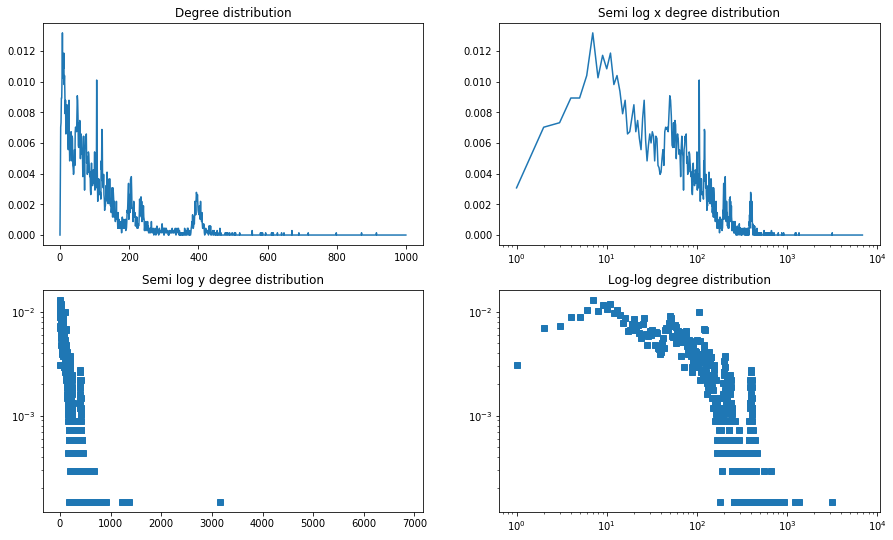

In [10]:
print_distribution(g, a=1000)

The previous plots show that the degree distribution of the network is complicated and doesn't fit exactly any of the basic network structures studied during the semester. However the last log-log plot suggests that a scale-free network with a power law could approximate the distribution. Let's make a regression to see what coefficient would fit. We use the `linear_model` function from sklearn.

The best linear approximation is y = [[-1.06933683]]x + [-1.40567422].
R2 value for the regression : 0.6266395358926462


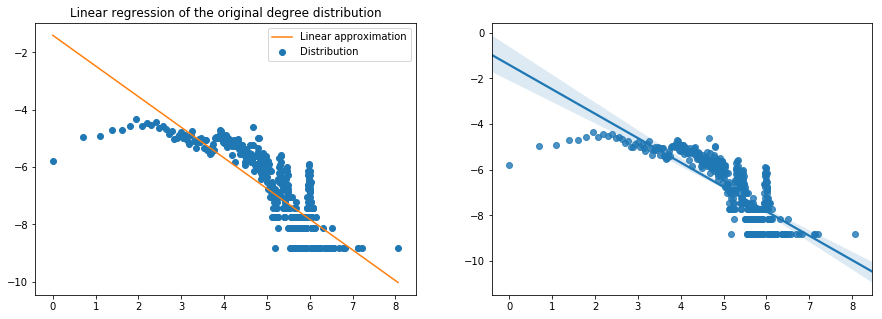

In [11]:
linear_regression_coefficient(g, title='Linear regression of the original degree distribution')

The value of $R^2$ is not really close to 1 but a scale free network model does not seem too bad anyway.

We will later use that regression to build an approximation of the network. We make the assumption that the network distribution follows a power law of coefficient -1.0693.

### 3.1.2) Modelisation with usual graphs models <a class="anchor" id="Modelisation with usual graphs models"></a>

#### Erdős–Rényi graph

The Erdős–Rényi graph models a random network where each pair of nodes has a fixed probability to be linked. We want this network to have the same number of nodes as the original one, and approximate the number of edges as much as possible.

In [12]:
p = 2 * nEdges / nNodes / (nNodes - 1)

print('The probability hyper-parameter giving the best approximation of the number of edges is {}'.format(np.round(p, 4)))

The probability hyper-parameter giving the best approximation of the number of edges is 0.0158


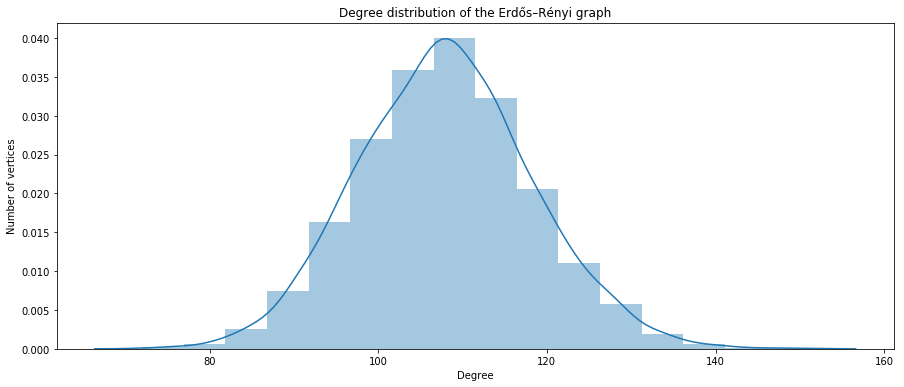

In [13]:
er = nx.erdos_renyi_graph(nNodes, p)

plot_degree_distribution(er, title='Degree distribution of the Erdős–Rényi graph')

As expected, it clearly doesn't match the distribution of our network. The random networks have a Poisson degree distribution (when the number of nodes is large) and it doesn't fit to the observed distribution.

#### Barabási-Albert

The Barabási-Albert graph follows a power law distribution (in theory $p(k) = C \times k^{-3}$) so we can hope much better results than with the Erdős–Rényi model. The number of nodes that we want in the graph is fixed and we can only play with the parameter specifying the number of edges to attach from a new node to existing nodes. With the trial and error method, we found out that setting this parameter to 54 gives the closest number of edges to our original graph.

This Barabási-Albert network has 365904 edges while our original network has 367483 edges.


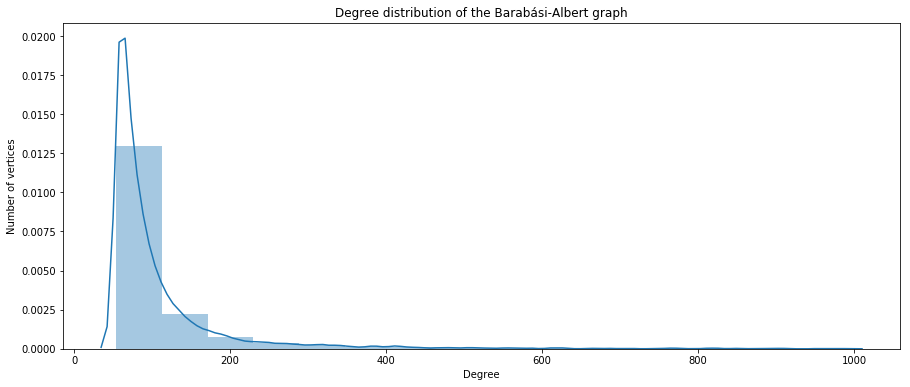

In [14]:
ba = nx.barabasi_albert_graph(nNodes, 54)

print('This Barabási-Albert network has {0} edges while our original network has {1} edges.'.format(ba.size(), nEdges))

plot_degree_distribution(ba, title='Degree distribution of the Barabási-Albert graph')

It indeed seems to be a power law distribution. Let's have a deeper insight and try to measure the parameter of this power law. The coefficient of such a random graph should be 3 in theory.

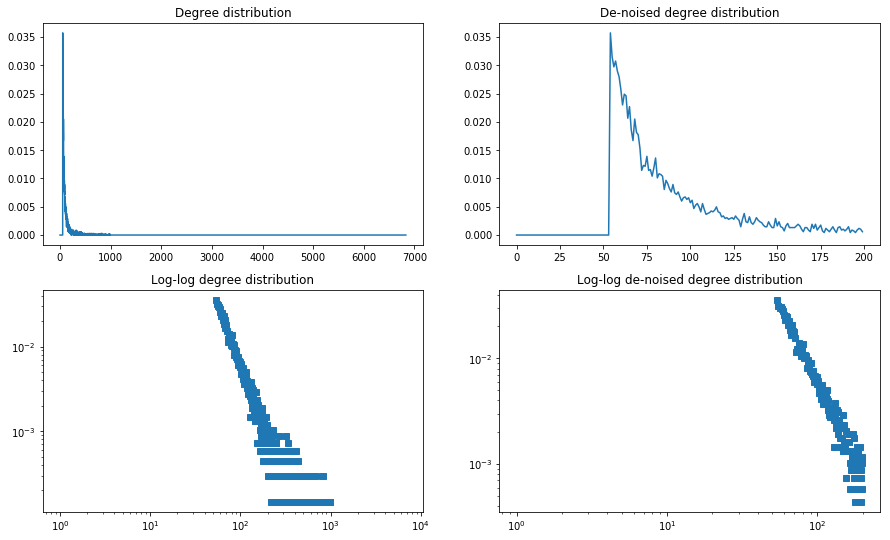

In [15]:
print_denoised_degree_distribution(ba, b=200, d=200)

Regression to measure the model law's coefficient

The best linear approximation is y = [[-2.73263079]]x + [ 7.35488586].
R2 value for the regression : 0.9139949509608049


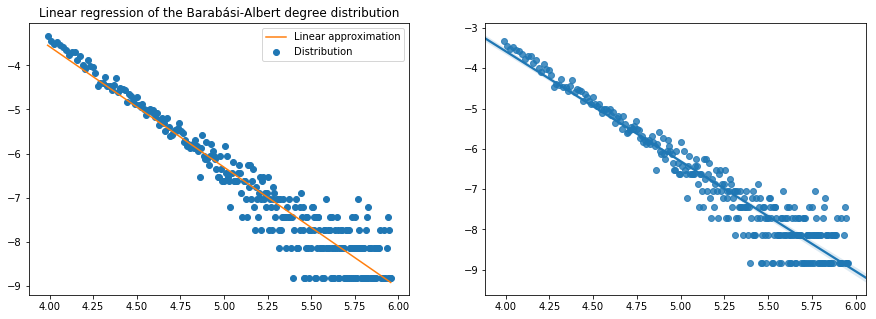

In [16]:
linear_regression_coefficient(ba, limit=300, title='Linear regression of the Barabási-Albert degree distribution')

We get a coefficient 2.7 that is close to 3 the expected value. Thus this network will be a better approximation than the random network precedently exposed but is still not ideal : we would like a power law network whose coefficient is closer to 1.0693 as computed earlier.

#### Comparison between the collected and the Barabási-Albert network distributions

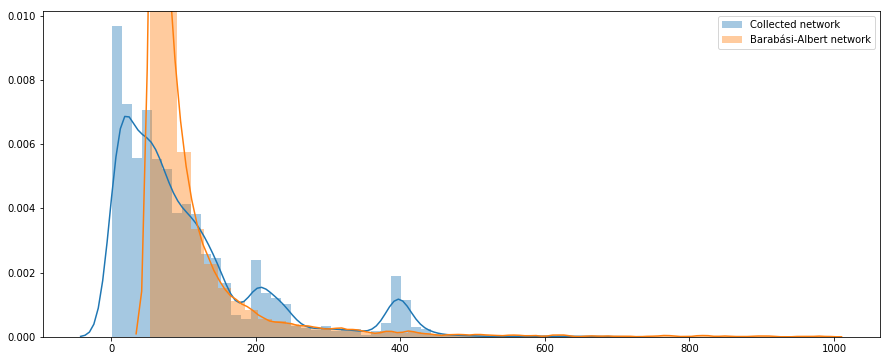

In [17]:
ba_degrees = list(dict(ba.degree()).values())

f, ax = plt.subplots(figsize=(15, 6))

sns.distplot(degrees_truncated, label='Collected network', ax=ax)
sns.distplot(ba_degrees, label='Barabási-Albert network', ax=ax)

plt.legend(loc='upper right')
plt.show()

We clearly see here that it is a better approximation than the Erdős–Rényi graph but is still not ideal.

### 3.1.3) A power law network with the right exponent <a class="anchor" id="A power law network with the right exponent"></a>

In this section we are trying to make a power law network with a closer exponent to the one measured in the regression of the original network. We didn't find any method to make a graph with the exact exponent but we approximated it with the following code.

The `configuration_model` method from NetworkX allows us to create a graph from a given list of degrees.

In order to create a list of degrees respecting a power law distribution of coefficient $\gamma$, we use the function `powerlaw_sequence` from NetworkX. However this function can return zeros and we don't want to do that because our graph is connected. So what we do is generate each degree one at a time and check that it's not 0.

In [19]:
while True:
    # Iterate the construction of a degree sequence until we find one that has a pair sum
    # (this is a requirement of the function configuration_model)
    s = []
    while len(s) < nNodes:
        # generate degrees one at a time
        nextval = int(nx.utils.powerlaw_sequence(1, 1.8)[0])
        if nextval != 0:
            s.append(nextval)
    if sum(s) % 2 == 0:
        # we found a proper distribution, can break!
        break

power_law = nx.configuration_model(s)
power_law = nx.Graph(power_law) # remove parallel edges
power_law.remove_edges_from(power_law.selfloop_edges())

print('This power law network has {0} nodes and {1} edges.'.format(len(power_law), power_law.size()))

This power law network has 6830 nodes and 24675 edges.


We note right now that the number of edges in this model is really lower to the value in the collected network (367483).

It seems that the lowest coefficient we can set for the power law is 1.5. All the other attemps with smaller coefficient have crashed.

We can check that it indeed follows a power law distribution :

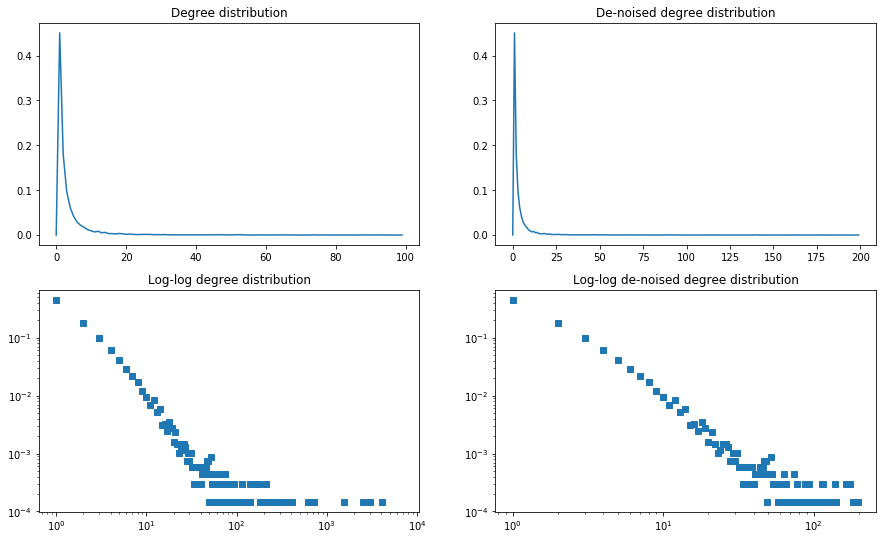

In [20]:
print_denoised_degree_distribution(power_law, a=100, b=200, d=200)

And we calculate here the coefficient of the power law :

The best linear approximation is y = [[-1.92499569]]x + [-0.38749095].
R2 value for the regression : 0.9508509908660382


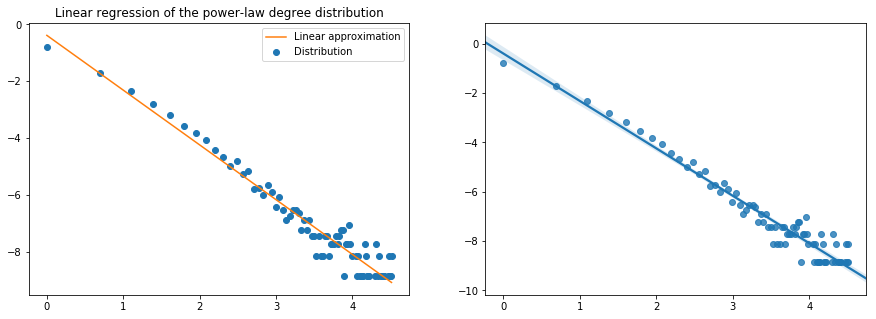

In [21]:
linear_regression_coefficient(power_law, limit=79, title='Linear regression of the power-law degree distribution')

It's indeed closer to the original network but there is still a little gap (reminder, the obtjective is 1.0693). However as noted earlier, the number of edges of this power law network is extremely low compared to the original network. It seems like the Barabási-Albert network is a better approximation even if the fit of the distribution is not as good.

The following plot comparing the obtained degree distribution to the original one confirms that the Barabási-Albert network is a better approximation.

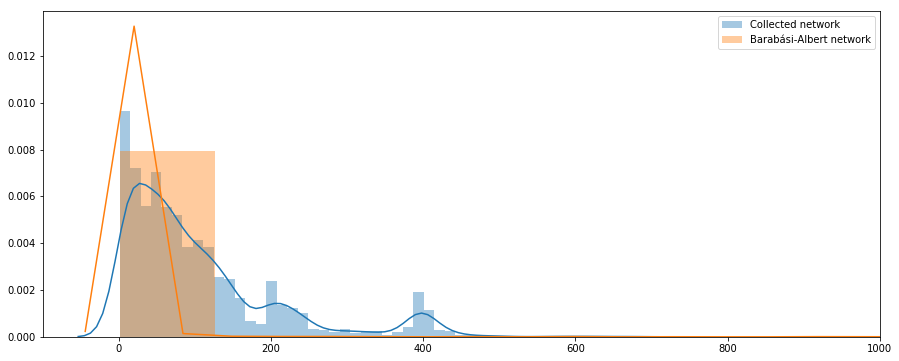

In [74]:
pl_degrees = list(dict(power_law.degree()).values())

f, ax = plt.subplots(figsize=(15, 6))

sns.distplot(degrees_truncated, label='Collected network', ax=ax)
sns.distplot(pl_degrees, label='Barabási-Albert network', ax=ax)

plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-100, 1000])
plt.show()

### 3.1.4 Comparison of the models <a class="anchor" id="Comparison of the models"></a>

#### Giant components

In this part we are analyzing the giant components of the original network and of the models.

In [34]:
giant_g = max(nx.connected_component_subgraphs(g), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
giant_pl = max(nx.connected_component_subgraphs(power_law), key=len)

print('Size of the giant component / Size of the network ')
print('Collected network : \t {}/{}'.format(len(giant_g.nodes()), len(g.nodes())))
print('Erdős–Rényi model : \t {}/{}'.format(len(giant_er.node()), len(er.nodes())))
print('Barabási-Albert model :  {}/{}'.format(len(giant_ba.nodes()), len(ba.nodes())))
print('Power law model : \t {}/{}'.format(len(giant_pl.nodes), len(power_law.nodes)))

Size of the giant component / Size of the network 
Collected network : 	 6830/6830
Erdős–Rényi model : 	 6830/6830
Barabási-Albert model :  6830/6830
Power law model : 	 6826/6830


The original network, the Erdős–Rényi and the Barabási-Albert graphs are fully connected. The modelisation with the last power law network has also a very big giant component and is almost fully connected. We can conclude that the connectedness of the network is respected.

#### Clustering coefficient

The average clustering coefficient measures the overall degree of clustering in the network. Real-world networks tend to have a higher average clustering coefficient because of their ability to have compact groupements of nodes so we expect it to be greater than the models.

In [35]:
avg_clustering_g = nx.average_clustering(g)
avg_clustering_er = nx.average_clustering(er)
avg_clustering_ba = nx.average_clustering(ba)
avg_clustering_pl = nx.average_clustering(power_law)

print('Clustering coefficients')
print('Collected network : \t {}'.format(np.round(avg_clustering_g, 3)))
print('Erdős–Rényi model : \t {}'.format(np.round(avg_clustering_er, 3)))
print('Barabási-Albert model :  {}'.format(np.round(avg_clustering_ba, 3)))
print('Power law model : \t {}'.format(np.round(avg_clustering_pl, 3)))

Clustering coefficients
Collected network : 	 0.643
Erdős–Rényi model : 	 0.016
Barabási-Albert model :  0.048
Power law model : 	 0.452


The last model created following a power law has the closest clustering coefficient. However, the really low number of edges is critical to make it a good model.

### 3.1.5) Comparison with common networks from the web <a class="anchor" id="Comparison with common networks from the web"></a>

Most scale-free networks follow a distribution of the form $p(k) = C\times k^{-\gamma}$ where $2 < \gamma < 3$ usually. In the approximation by a power law distribution we made, we found out that $\gamma \simeq 1.0693$ which is not really a common value as the following array shows (values seen during the lectures).


| Network              | Gamma |
|----------------------|-------|
| WWW in               | 2.00  |
| WWW out              | 2.31  |
| Emails in            | 3.43  |
| Emails out           | 2.03  |
| Actor                | 2.12  |
| Protein interactions | 2.12  |
| Citations in         | 3.03  |
| Citations out        | 4.00  |

Is a scale free network such a good model for our collected network ? We saw that the fit is not too bad but there are also more empirical reasons for such a model.

We may wonder why a scale free network seems to be a good approximation of the collected network. One of the most notable caracteristic of a scale free network is the presence of nodes with a degree much larger than the average which is the case here :

In [36]:
print('Average degree : {}'.format(np.round(np.mean(degrees), 1)))
print('{} nodes with degree 5 times bigger.'.format(np.count_nonzero(degrees > 5*np.mean(degrees))))
print('{} nodes with degree 10 times bigger.'.format(np.count_nonzero(degrees > 10*np.mean(degrees))))

Average degree : 107.5
23 nodes with degree 5 times bigger.
4 nodes with degree 10 times bigger.


It's in fact quite intuitive when you know that the network is composed of nodes representing wikipedia webpages and being linked if there is a link directing from one of the page to the other one. We expect a few large hubs (Wikipedia pages covering an important subject) appearing in such a network, followed by smaller ones (moderately important subjects) in a larger proportion and finally quite a lot of minor ones. The plots above show that the distribution respects that trend pretty much, except that there are fewer minor and very important topics that in a real scale free network.

This difference is likely to come directly from our **sampling method**. Indeed as we start from a central node and stop the collection somewhere, central nodes are important and at the *end* of the network we get what looks like minor pages. Those one could have been important if we had pushed the collection one hop further from the root node.

The preferential attachment process is another intuitive way to understand why the scrapped network looks like a scale free network. This process is also known as "the rich get richer and the poor get poorer" : a quantity (here the links between the nodes) is distributed according to how much they already have. It has been shown that such a process produces scale free networks and most algorithms (like the Barabási-Albert one) use this principle to create such networks. Regarding wikipedia, the more popular a page is and the more the topic is important, the more links it will have and conversely for lesser known pages. It is exactly a **preferential attachment** phenomena.

## 3.2) Community detection using Spectral clustering <a class="anchor" id="Community detection using Spectral clustering"></a>


We will try to use the collected data to answer our problem which is: 
 **Can we isolate communities of pages just by looking at the hyperlink graph ? **
 
This is the famous community detection problem for which a popular method is the [Louvain Algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity).
 
The measure of performance we will use for the community detection is the modularity. Modularity measures the strengh of the division of a network into sub-groups. A network with high modularity has dense intra-connections (within sub-groups) and sparse inter-connections (between different groups).

Louvain as been presented in 2008 and though it has been improved [[1](https://link.springer.com/chapter/10.1007/978-3-319-11683-9_12)], we will use this as a baseline to compare the performance of spectral clustering for community detection.

The steps are the following :
 * Louvain algorithm as a baseline
 * Spectral clustering
 * Visualization of the communities

In [37]:
from utils import get_bag_of_communities

### 3.2.1) Louvain community detection <a class="anchor" id="Louvain community detection"></a>

We use the Python library [`community`](https://pypi.python.org/pypi/python-louvain/0.3) that implements the Louvain algorithm.

This library also allows us to compute the modularity of a given partition of the nodes.

In [38]:
louvain_partition = community.best_partition(g)

In [39]:
louvain_modularity = community.modularity(louvain_partition, g)
louvain_modularity

0.7879634419028008

In [40]:
k_louvain = len(set(louvain_partition.values()))
print('Louvain algorithm found {} communities'.format(k_louvain))

Louvain algorithm found 16 communities


We can try to visualize the categories of the nodes in each of these communities. From the scraping, we got for each page a list of categories in which the page belongs. Let's compute for each community what we'll call a bag of categories that is the list of all the categories of the nodes it contains and the count of the number of nodes that belong to this category for each one.

The function can be found in `utils.py`, it's implementation is quite straight-forward.

In [41]:
louvain_bag = get_bag_of_communities(network, louvain_partition)

Let's get the number of pages in each community.

In [42]:
louvain_counts = [0 for _ in range(k_louvain)]
for i, title in enumerate(louvain_partition.keys()):
    louvain_counts[louvain_partition[title]] += 1

Now we want to visualize the categories of the nodes in each community. We print for each community the 10 most represented categories of the community.

In [43]:
for i in range(k_louvain):
    sorted_bag = sorted(louvain_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Community {}/{} ({} pages) : '.format(i+1, k_louvain, louvain_counts[i]))
    for ind in range(10):
        print(sorted_bag[ind])

 
Community 1/16 (361 pages) : 
('Formula One constructors', 123)
('Formula One entrants', 115)
('British auto racing teams', 47)
('British racecar constructors', 47)
('Use British English from July 2015', 42)
('24 Hours of Le Mans drivers', 28)
('Italian racecar constructors', 26)
('Italian auto racing teams', 25)
('Formula E drivers', 23)
('British Formula Three Championship drivers', 20)
 
Community 2/16 (366 pages) : 
('MacOS', 70)
('IOS (Apple)', 33)
('Apple Inc. executives', 33)
('Apple Inc. software', 26)
('Apple Inc.', 23)
('Apple Inc. services', 22)
('IOS software', 22)
('Classic Mac OS', 21)
('MacOS-only software made by Apple Inc.', 20)
('Macintosh stubs', 20)
 
Community 3/16 (690 pages) : 
('Best Original Song Academy Award-winning songwriters', 114)
('Grammy Award winners', 94)
('Best Original Song Academy Award-winning songs', 80)
('Songwriters Hall of Fame inductees', 62)
('Music infoboxes with deprecated parameters', 58)
('Perry Como songs', 57)
('20th-century American

We can see that we get some nice results because it seems that a general topic can be infered for each community. The topics are: 

| Alphabetical Order              |
|---------------------------------|
| Aircrafts                       |
| American Footbal                |
| Animals / mammals               |
| Apple inc.                      |
| British ships                   |
| Cars                            |
| Comics and fictional characters |
| Electronics                     |
| Car racing                      |
| Luxury in Britain               |
| Mexican soccer                  |
| Music instruments               |
| Rugby                           |
| Social science                  |
| Songwriters                     |
| Weapons                         |

### 3.2.2) Spectral Clustering <a class="anchor" id="Spectral Clustering"></a>

Nows let's try a spectral clustering approach for this community detection problem.

#### 3.2.2.1 Using the natural graph

The first idea is to use the natural graph, that is each node is a page and there is an edge of weight 1 between two pages if one of the pages links to the other.

We define the graph laplacian using the formula $L = D- A$ where $D$ is the diagonal matrix containing the degrees and $A$ is the adjacency matrix.

In [44]:
laplacian = np.diag(degrees) - adj.todense()
laplacian = sparse.csr_matrix(laplacian)

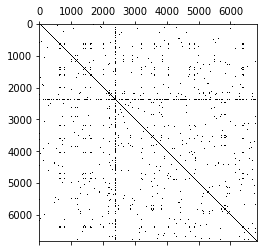

In [45]:
plt.spy(laplacian.todense())

In order to do spectral clustering using this Laplacian, we need to compute the $k$ first eigenvalues and corresponding eigenvectors. We get a matrix $U$ of $\mathbb{R}^{n \times k}$ where $n$ is the number of nodes in the graph. Applying a k-means algorithm in order to clusterize the $n$ vectors of $\mathbb{R}^k$ corresponding to the lines of $U$ gives us a clustering of the $n$ nodes.

Here we need to specify the number of clusters (communities) we want to look for. As a reminder, Louvain returned 16 communities (it seems that it gives the maximum modularity but let's recall that Louvain is a heuristic so we are not sure of that).

Later in this notebook (at the end of the development of the model), we run some sort of cross-validation on the parameter `k_spectral`. For different values, we run the algorithm 5 times and take the mean and standard deviation of the modularity. It seems that 21 gives the best results. Please see below for details on this.

In [46]:
k_spectral = 21

In [47]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian.asfptype(), k=k_spectral, which='SM')

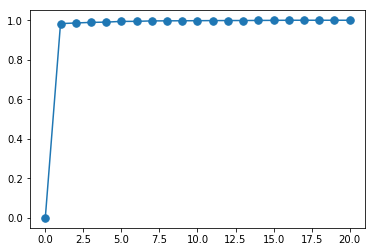

In [48]:
plt.plot(eigenvalues, '.-', markersize=15)

In [50]:
eigenvalues[:2]

array([1.42111982e-13, 9.82882793e-01])

We check that the first eigenvalue is 0 but the second is not. The graph is connected.

Now we clusterize the resulting vectors in $\mathbb{R}^k$

In [51]:
centroids, labels = cluster.vq.kmeans2(eigenvectors, k_spectral)

/usr/local/lib/python3.5/dist-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


This warning shows that at least one of the clusters is empty.

In order to get a first idea of how this algorithm did, let's look at the number of nodes in each cluster.

In [52]:
cc = [0 for i in range(k_spectral)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

'1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 6809, 1, 1, 1, 4, 1, 2, 2, 1, 1'

We can see that with almost all the clusters containing less than 3 nodes, this first algorithm did not perform really well.

#### 3.2.2.2 Building another graph

As we have seen in class and in one of the homework. In order for spectral clustering to work, we need to assign edge weights that are stronger the closer the nodes are.

Let's build another graph with still the same vertex but some new edges between them.

We have already computed the distances in the graph let's define edges with weights using a kernel (e.g. the Gaussian kernel).

In [53]:
kernel_width = distances.mean()
weights = np.exp(-np.square(distances)/kernel_width**2)

np.fill_diagonal(weights, 0)

This creates a complete graph. We could sparsify it for faster computations but this is not really long and experience seems to show that results are better with the full graph.

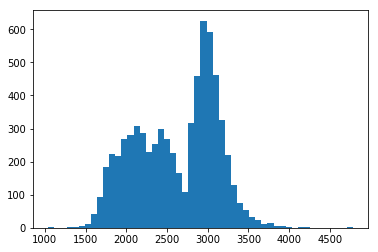

In [54]:
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50);

In [55]:
laplacian = np.diag(1/np.sqrt(degrees)).dot((np.diag(degrees) - weights).dot(np.diag(1/np.sqrt(degrees))))

We can check that the obtained Laplacian matrix is symmetric.

In [56]:
tol = 1e-8
np.allclose(laplacian, laplacian.T, atol=tol)

True

In [57]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, k_spectral-1))

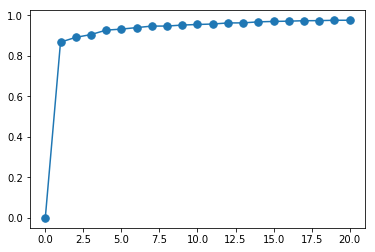

In [58]:
plt.plot(eigenvalues, '.-', markersize=15)

In [59]:
centroids, labels = cluster.vq.kmeans2(eigenvectors, k_spectral)

In [60]:
cc = [0 for i in range(k_spectral)]
for i in labels:
    cc[i] += 1
', '.join([str(i) for i in cc])

'468, 129, 407, 388, 280, 181, 239, 368, 180, 292, 121, 448, 130, 166, 177, 191, 578, 457, 1165, 179, 286'

This seems better. We get pages distributed among all the clusters (with somme clusters more important than the others of course).

First let's have a look at the categories of each cluster.

In [61]:
spectral_partition = {}
for i, title in enumerate(network.keys()):
    spectral_partition[title] = labels[i]

In [62]:
spectral_bag = get_bag_of_communities(network, spectral_partition)

In [63]:
spectral_counts = [0 for _ in range(k_spectral)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1

In [64]:
for i in range(k_spectral):
    sorted_bag = sorted(spectral_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Community {}/{} ({} pages) : '.format(i+1, k_spectral, spectral_counts[i]))
    if spectral_counts[i] > 0:
        for ind in range(10):
            print(sorted_bag[ind])

 
Community 1/21 (468 pages) : 
('Formula One constructors', 87)
('Formula One entrants', 80)
('British auto racing teams', 36)
('British racecar constructors', 36)
('Use British English from July 2015', 28)
('Italian racecar constructors', 16)
('Formula Two entrants', 15)
('Italian auto racing teams', 15)
('Breguet aircraft', 13)
('Formula One stubs', 13)
 
Community 2/21 (129 pages) : 
('Liga MX seasons', 73)
('Liga MX teams', 18)
('Ascenso MX teams', 10)
('Liga MX players', 10)
('Mexican footballers', 9)
('Chiapas F.C. managers', 8)
('Football clubs in Mexico', 7)
('Chiapas F.C. footballers', 7)
('Mexican football managers', 6)
('Primera Fuerza', 6)
 
Community 3/21 (407 pages) : 
('Ship infoboxes without an image', 21)
('Empire ships', 12)
('Steamships of the United Kingdom', 10)
('Steamships of the United States', 9)
('Football team templates which use American parameter', 9)
('Maritime incidents in March 1942', 8)
('Single-engined tractor aircraft', 8)
('1943 ships', 8)
('Soccer 

It seems that we get the same results. As we asked for more communities than Louvain, some of them are split but it's either a duplicate or a finer separation.

There are some inconsistensies in the partition we get: 
- two communities for Songwriters
- three communities for Ship incidents 
- two communities for NFL
- two communities for mammals

but the community electronics is now split into video games and computer hardware.

So we get more communities. Sometimes its just duplicates but sometimes it is a finer separation of two groups.

In [65]:
spectral_modularity = community.modularity(spectral_partition, g)

In [66]:
spectral_modularity

0.5723048112302852

#### Testing different values of `k_spectral`

Here we test different values of k. It seems after some testing that there is a high variance in the modularity of partitions returned by the algo (for a given `k_spectral`). In order to find out if there is really a value better than the others. We compute the mean and variance of modularity for a given value by running 5 times the algorithm.

In [67]:
"""cross_val = {}
for k in tqdm_notebook(range(10, 30)):
    tmp = []
    for _ in range(5):
        eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, k-1))
        centroids, labels = cluster.vq.kmeans2(eigenvectors, k)
        spectral_partition = {}
        for i, title in enumerate(network.keys()):
            spectral_partition[title] = labels[i]
        spectral_modularity = community.modularity(spectral_partition, g)
        tmp.append(spectral_modularity)
    cross_val[k] = [np.mean(tmp), np.std(tmp)]
    
save_obj(d, 'cross_val')"""

"cross_val = {}\nfor k in tqdm_notebook(range(10, 30)):\n    tmp = []\n    for _ in range(5):\n        eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, k-1))\n        centroids, labels = cluster.vq.kmeans2(eigenvectors, k)\n        spectral_partition = {}\n        for i, title in enumerate(network.keys()):\n            spectral_partition[title] = labels[i]\n        spectral_modularity = community.modularity(spectral_partition, g)\n        tmp.append(spectral_modularity)\n    cross_val[k] = [np.mean(tmp), np.std(tmp)]\n    \nsave_obj(d, 'cross_val')"

As this computation takes approximately one hour to terminate, the results have been stored in a pickle file.

In [68]:
cross_val = load_obj('cross_val')
cross_val

{10: [0.5461446643531513, 0.014204021512990739],
 11: [0.5384863265574735, 0.05735896525546241],
 12: [0.5226832396829054, 0.06819879413736309],
 13: [0.5533351870487171, 0.038818054236607814],
 14: [0.5381651600658637, 0.04699507180368727],
 15: [0.5865118737167674, 0.04360118280418143],
 16: [0.5692134498770218, 0.03529209610081742],
 17: [0.5865481270865698, 0.035536723142459904],
 18: [0.5803603485387077, 0.05081587682393836],
 19: [0.5864370773133469, 0.030512583730477282],
 20: [0.5912985115025478, 0.01910266718815081],
 21: [0.624789163803509, 0.026225410477092505],
 22: [0.5861561201449181, 0.0356803881976126],
 23: [0.5850799156459467, 0.021497274805815723],
 24: [0.599679165273453, 0.00857302800808383],
 25: [0.581851950930606, 0.05697908989489959],
 26: [0.5611675652007942, 0.0396347612280689],
 27: [0.5727729550668124, 0.025856710323085143],
 28: [0.5791313467241119, 0.023406613568091705],
 29: [0.5999388395947497, 0.02302581686076951]}

We see that the best modularity seems to be achieved with the parameter k of 21. However we note that the standard deviation is quite high in all the cases.

### 3.2.3 Comparison of the two methods <a class="anchor" id="Comparison of the two methods"></a>

It seems that no matter the value of `k` we choose, we wont be able to have a higher modularity than the one achieved by the Louvain algorithm. So what could be the advantages of the spectral approach ?
* Computational cost :
    - Louvain algo : greedy algorithm that appears to run in $0(n \log n)$ where $n$ is the number 
    of nodes in the network.
    - Spectral clustering : the computation of the Laplacian is already in $O(n^3)$ and that's without counting the shortest-paths matrix whose computation is costly $O(|E|+|V|\log |V|)$ using the Dijkstra algorithm. As we have many edges this is really costly.
    
The spectral clustering seems really more costly than the Louvain method. That's is something we had noticed in our study.

* Better communities ? 
    - We have seen that the communities are not better in the sense of the modularity (measuring the internal cohesion of communities versus the separation of different ones). 
    - Could the partition could be better when it comes to the categories of the nodes ? In order to be able to measure that, we could apply a NLP pipeline on the categories of the pages to do Topic Selection. This could give us a more precise idea of the performance of the split when it comes to topics (and not only modularity).

### 3.2.4 Visualization <a class="anchor" id="3.2.4Visualization"></a>

Using Gephi, we were able to get some nice visualizations of our clustering.

In [69]:
for i in louvain_partition.keys():
    louvain_partition[i] = str(louvain_partition[i])
for i in spectral_partition.keys():
    spectral_partition[i] = str(spectral_partition[i])

NetworkX requires all the node attributes to be strings to export them.

In [70]:
nx.set_node_attributes(g, louvain_partition, 'louvain')
nx.set_node_attributes(g, spectral_partition, 'spectral')

In [71]:
nx.write_graphml(g, "data/full_graph.graphml")

Now opened in Gephi, this is what our graph looks like.

We used a repulsive layout in order to make the graph the more readable possible. Nodes in the same community are in the same color.

<img src="images/1.png" style="width: 700px;">

We can look more closely to some communities, for example the Apple one : 

<img src="images/apple.png" style="width: 500px;">

or the mexican soccer one: 

<img src="images/mexican_soccer.png" style="width: 500px;">

Some additional screenshots are provided in the folder images/. Feel free to have a look at different communities.

#### Comparison of the two communities: 

Here is a view of the communities obtained by spectral clustering first and below by Louvain algorithm.

<img src="images/1.png" style="width: 200px;">
<img src="images/2.png" style="width: 200px;">


Sure the layout is the same because the graph is the same. What is interesting to note is that the two clustering look approximately alike.

# 4) Conclusion <a class="anchor" id="Conclusion"></a>

In this study, we first collected a sample network of the Wikipedia hyperlink graph. We tried different approaches using either the wikipedia API or the scraping of the raw pages. Eventually we managed to get a significant sample (6830 nodes) in a reasonable time (3 hours). The use of disambiguation pages proved to be handy to get a large variety of pages from a single root node.

Then we tried to model this collected network using usual network structures. The various plots of the degree distribution suggest that a power distribution of the degrees can be a good approximation. The Barabási-Albert model turned out to be the best approximation as it fits the collected network on many of its properties (number of nodes and edges, degrees distribution, shape of giant component).

Eventually we answered our initial question that was to know if the structure of the graph bears information on the content of the nodes. That proved to be true as we could extract communities of categories only by looking at proximity features. The Louvain algorithm seemed to provide a better community detection than the spectral clustering algorithm. It indeed gives a better modularity and is faster to run. We checked that the extracted communities share a common topic by visualizing the clusters using for example Gephi.

In order to continue our study we could try to measure properly the fit of the community detection with the categories of the nodes by implementing a natural language processing pipeline on those categories in order to extract topics.